# start

In [17]:
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

# functions

In [18]:
def calc_jackknife_mean_and_error(
        x: np.ndarray):
    """Return jackknife estimates of means and errors for independent Markov
    chains. First axis of x is timestep, remaining axes are left intact."""
    means = []
    for t in range(x.shape[0]):
        means.append(np.delete(x, t, 0).mean(0))
    means = np.array(means)
    mean = means.mean(0)
    error = np.sqrt((x.shape[0]-1)*((means-mean)**2).mean(0))
    return mean, error

def calc_autocorr_func_at_t(
        x: np.ndarray,
        t: int):
    """Return measured values of autocorrelation function at timestep t for
    independent (but identically distributed) Markov chains. First axis of x is
    timestep, remaining axes are left intact."""
    global_mean = x.mean()
    if t == 0:
        return ((x-global_mean)**2).mean(0)
    else:
        return ((x[:-t]-global_mean)*(x[t:]-global_mean)).mean(0)

def calc_autocorr_func_and_time(
        x: np.ndarray,
        t_max: int):
    """Return estimates of autocorrelation function up to t_max and integrated
    autocorrelation time, including jackknife error estimates."""
    autocorr_func_vals = []
    autocorr_func_mean_and_error = []
    for t in range(t_max):
        autocorr_func_at_t = calc_autocorr_func_at_t(x, t)
        autocorr_func_vals.append(autocorr_func_at_t)
        autocorr_func_mean_and_error.append(
            calc_jackknife_mean_and_error(autocorr_func_at_t))
    autocorr_func_vals = np.array(autocorr_func_vals)
    autocorr_func_mean_and_error = np.array(autocorr_func_mean_and_error)
    autocorr_time = 0.5 + (autocorr_func_vals[1:]/autocorr_func_vals[0]).sum(0)
    autocorr_time_mean, autocorr_time_error = \
        calc_jackknife_mean_and_error(autocorr_time)
    return autocorr_func_mean_and_error, autocorr_time_mean, autocorr_time_error

# correlated data

Generate $n_{chains}$ independent Markov chains of correlated Gaussian noise data with $n_{steps}$ timesteps each. Correlation strength controlled by parameter $r \in [0,1]$ (larger values ~ stronger correlation).

In [19]:
n_chains = 100
n_steps = 1000
r = 0.9

x = [np.random.randn(n_chains)]
for _ in tqdm(range(n_steps)):
    x.append(r*x[-1] + np.sqrt(1-r**2)*np.random.randn(n_chains))
x = np.array(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot some example chains.

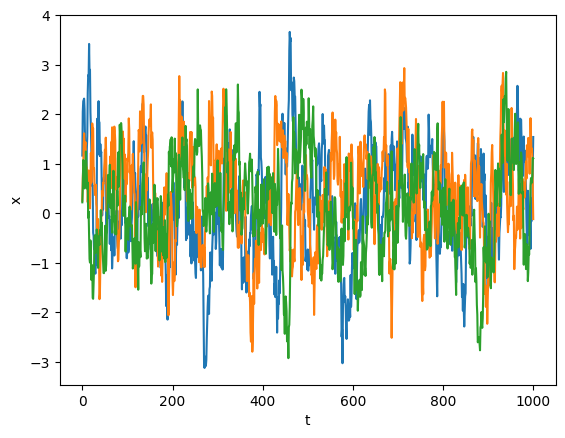

In [20]:
plt.xlabel('t')
plt.ylabel('x')
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])

# autocorrelation at fixed $t_{max}$

Compute mean and error estimates of the autocorrelation function and integrated autocorrelation time at fixed window size $t_{max} = n_{steps}$.

In [21]:
t_max = n_steps
autocorr_func, autocorr_time_mean, autocorr_time_error = \
    calc_autocorr_func_and_time(x, t_max)
print(f't_int = {autocorr_time_mean} +/- {autocorr_time_error}')

t_int = 16.76220656169693 +/- 5.314510954974412


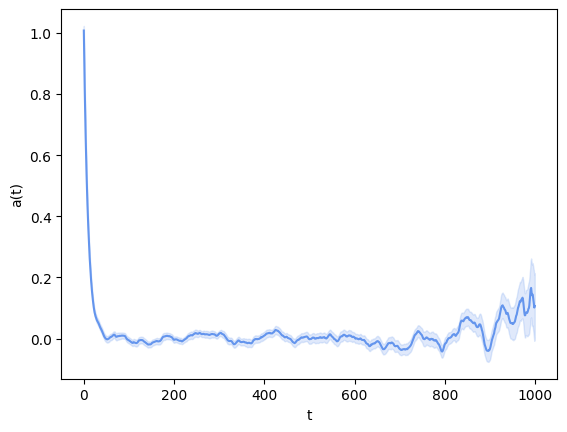

In [22]:
plt.xlabel('t')
plt.ylabel('a(t)')
plt.plot(
    list(range(t_max)),
    autocorr_func[:,0],
    color='cornflowerblue')
plt.fill_between(
    list(range(t_max)),
    autocorr_func[:,0]-autocorr_func[:,1],
    autocorr_func[:,0]+autocorr_func[:,1],
    alpha=0.2,
    color='cornflowerblue')

One can see how the signal/noise ratio deteriorates at large $t$ due to the smaller number of data points available for estimating the autocorrelation function, implying the existence of an optimal window size smaller than $n_{steps}$.

# $\Gamma$ method

Automatically find optimal window size using the $\Gamma$ method, $c$ is a free parameter.

In [23]:
c = 10
t_max = 1
_, t_int, t_int_error = \
    calc_autocorr_func_and_time(x, t_max)
with tqdm(total=n_steps) as progress:
    while c*t_int > t_max:
        t_max += 1
        _, t_int, t_int_error = calc_autocorr_func_and_time(x, t_max)
        progress.update(1)
print(f'optimal window size: t_max = {t_max}')
print(f't_int = {t_int} +/- {t_int_error}')

  0%|          | 0/1000 [00:00<?, ?it/s]

optimal window size: t_max = 98
t_int = 9.709943390070137 +/- 0.5493642439010812


# end